# ML + Product Exercise: Churn Prediction as a PM

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/synthetic_customer_churn.csv')

# Data exploration

In [4]:
df.head()


,tenure_months,sessions_per_week,feature_usage,support_tickets,is_premium,churn
0,29,14,46,2,0,0
1,15,0,14,2,0,0
2,8,7,36,0,0,0
3,21,11,12,0,0,0
4,19,7,17,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   tenure_months      1500 non-null   int64
 1   sessions_per_week  1500 non-null   int64
 2   feature_usage      1500 non-null   int64
 3   support_tickets    1500 non-null   int64
 4   is_premium         1500 non-null   int64
 5   churn              1500 non-null   int64
dtypes: int64(6)
memory usage: 70.4 KB


In [14]:
df.describe()

,tenure_months,sessions_per_week,feature_usage,support_tickets,is_premium,churn
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,18.514667,6.887333,25.492667,1.181333,0.276000,0.242000
std,10.268922,4.290172,14.207434,1.063895,0.447166,0.428437
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,10.000000,3.000000,13.000000,0.000000,0.000000,0.000000
50%,19.000000,7.000000,26.000000,1.000000,0.000000,0.000000
75%,28.000000,11.000000,38.000000,2.000000,1.000000,0.000000
max,35.000000,14.000000,49.000000,5.000000,1.000000,1.000000


In [8]:
df.isnull().sum()

tenure_months        0
sessions_per_week    0
feature_usage        0
support_tickets      0
is_premium           0
churn                0
dtype: int64

In [6]:
X = df.drop('churn', axis=1)
y = df['churn']

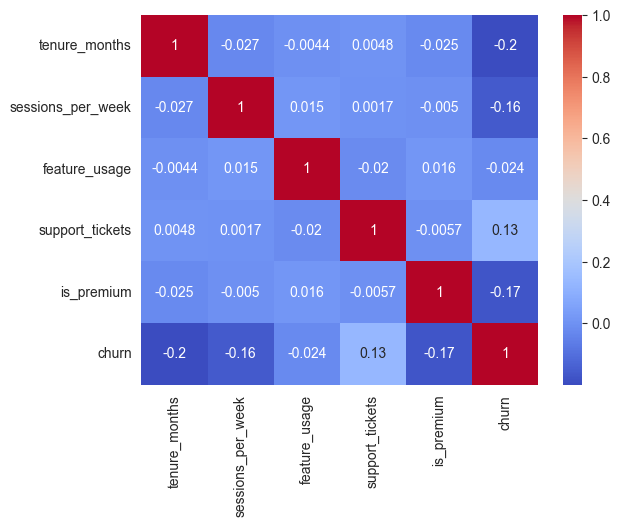

In [11]:
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


<Axes: xlabel='churn'>

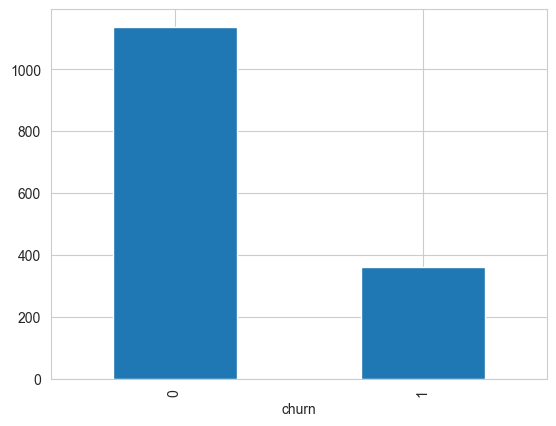

In [15]:
df.churn.value_counts().plot(kind='bar')

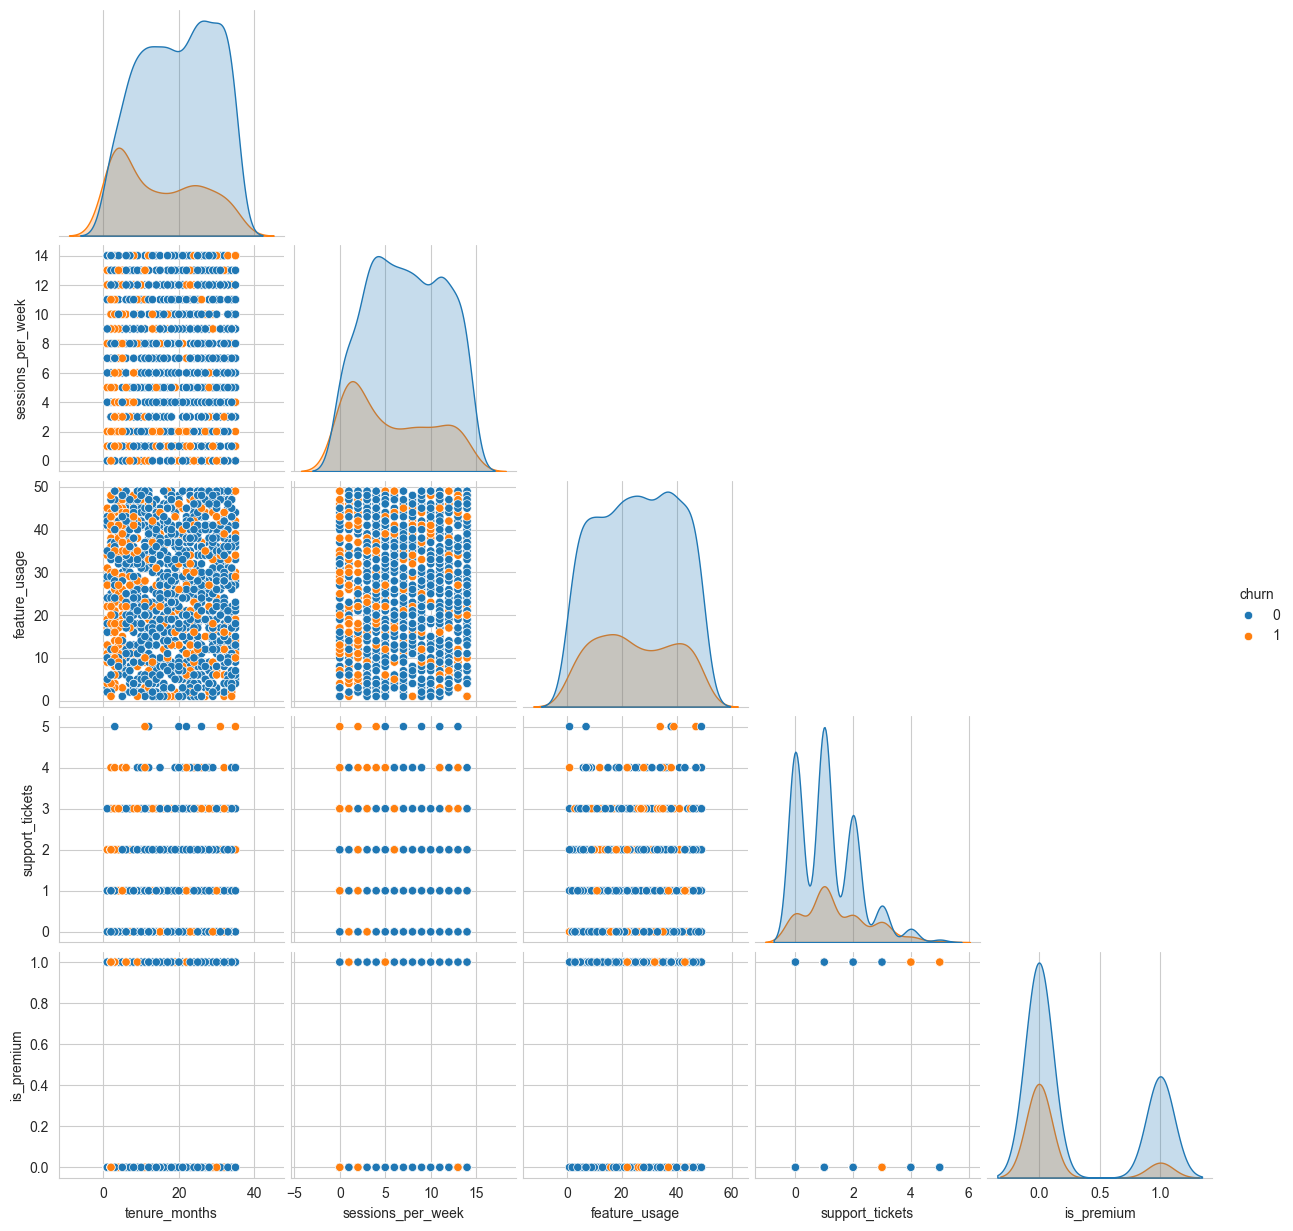

In [13]:
sns.pairplot(df,corner=True,hue='churn');

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logreg finetuning

In [107]:

logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
logreg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [108]:

coef = pd.Series(
    logreg.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

print(coef)


is_premium          -0.562682
tenure_months       -0.541004
sessions_per_week   -0.404014
support_tickets      0.403471
feature_usage        0.039924
dtype: float64


In [109]:
new_users = pd.DataFrame([
    {"tenure_months": 6, "sessions_per_week": 2, "feature_usage": 10, "support_tickets": 3, "is_premium": 0}
])

new_users_scaled = scaler.transform(new_users)
churn_prob = logreg.predict_proba(new_users_scaled)[:, 1]


In [110]:
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

logreg = LogisticRegression(class_weight="balanced", max_iter=5000)

param_grid_logreg = [
    # L2 regularization
    {"solver": ["lbfgs"], "penalty": ["l2"], "C": [0.01, 0.1, 1, 10, 100]},
    # L1 regularization (liblinear supports l1 for binary classification)
    {"solver": ["liblinear"], "penalty": ["l1", "l2"], "C": [0.01, 0.1, 1, 10, 100]},
]

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_logreg,
    n_jobs=-1
)

grid_logreg.fit(X_train_scaled, y_train)

best_logreg = grid_logreg.best_estimator_
print("LogReg best params:", grid_logreg.best_params_)
print("LogReg best CV ROC-AUC:", grid_logreg.best_score_)

test_auc_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1])
print("LogReg test ROC-AUC:", test_auc_logreg)


LogReg best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg best CV ROC-AUC: 0.6666666666666667
LogReg test ROC-AUC: 0.7003801822460926


In [111]:
from sklearn.linear_model import LogisticRegression

best_params = grid_logreg.best_params_

best_logreg_balanced = LogisticRegression(
    **best_params,
    class_weight="balanced",
    max_iter=5000
)

best_logreg_balanced.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.01
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mult

In [163]:
y_pred_default = best_logreg_balanced.predict(X_test_scaled)          # threshold = 0.5
y_proba_logreg = best_logreg_balanced.predict_proba(X_test_scaled)[:, 1]


In [164]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_default))


              precision    recall  f1-score   support

           0       0.86      0.65      0.74       227
           1       0.38      0.68      0.49        73

    accuracy                           0.66       300
   macro avg       0.62      0.67      0.62       300
weighted avg       0.75      0.66      0.68       300



In [165]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)
roc_auc = roc_auc_score(y_test, y_proba_logreg)


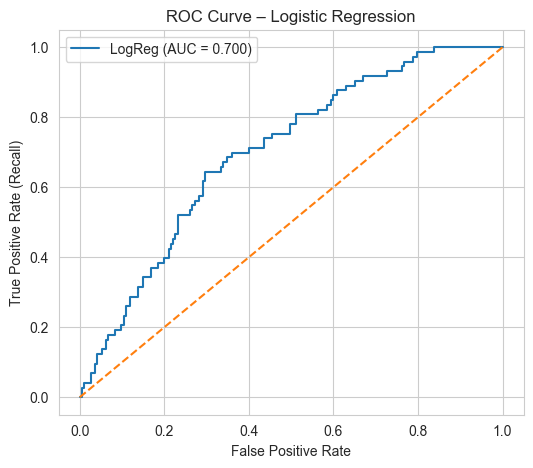

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


In [167]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)

target_recall = 0.8  # recall for class 1
idx = np.where(tpr >= target_recall)[0][0]

best_threshold = thresholds[idx]
print("Chosen threshold:", best_threshold)


Chosen threshold: 0.4360898652232931


In [168]:
y_pred_custom = (y_proba_logreg >= best_threshold).astype(int)


In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.89      0.49      0.63       227
           1       0.34      0.81      0.48        73

    accuracy                           0.57       300
   macro avg       0.61      0.65      0.55       300
weighted avg       0.75      0.57      0.59       300



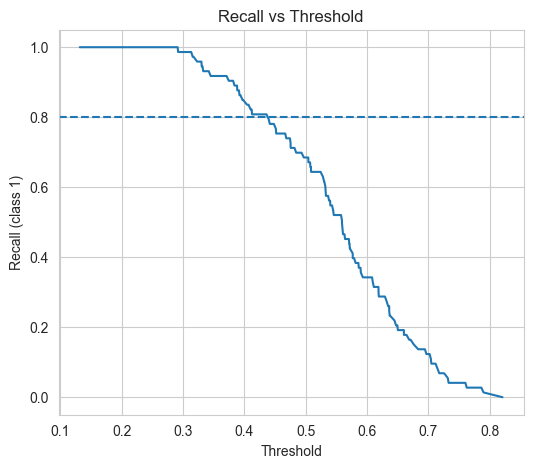

In [171]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_logreg)

plt.figure(figsize=(6, 5))
plt.plot(pr_thresholds, recall[:-1])
plt.axhline(0.8, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Recall (class 1)")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()


In [172]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_pred_custom)


print("Logistic Regression confusion matrix:\n", cm_lr)



Logistic Regression confusion matrix:
 [[111 116]
 [ 14  59]]


# KNN


In [136]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "weights": ["uniform", "distance"],
    "p": [1, 2],                 # 1=Manhattan, 2=Euclidean (Minkowski)
    "leaf_size": [10, 20, 30, 50]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)

best_knn = grid_knn.best_estimator_
print("KNN best params:", grid_knn.best_params_)
print("KNN best CV ROC-AUC:", grid_knn.best_score_)


KNN best params: {'leaf_size': 20, 'n_neighbors': 31, 'p': 1, 'weights': 'distance'}
KNN best CV ROC-AUC: 0.7495547555892383


In [137]:
from sklearn.metrics import roc_auc_score, classification_report

y_proba_knn = best_knn.predict_proba(X_test_scaled)[:, 1]
print("KNN test ROC-AUC:", roc_auc_score(y_test, y_proba_knn))


KNN test ROC-AUC: 0.7383078872729466


In [150]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn)

target_recall = 0.8
idx = np.where(tpr >= target_recall)[0][0]
best_threshold_knn = thresholds[idx]

print("Threshold for 100% recall:", best_threshold_knn)


Threshold for 100% recall: 0.17320205415733061


In [151]:
y_pred_knn = (y_proba_knn >= best_threshold_knn).astype(int)
print(classification_report(y_test, y_pred_knn))


              precision    recall  f1-score   support

           0       0.90      0.53      0.66       227
           1       0.36      0.81      0.49        73

    accuracy                           0.60       300
   macro avg       0.63      0.67      0.58       300
weighted avg       0.76      0.60      0.62       300



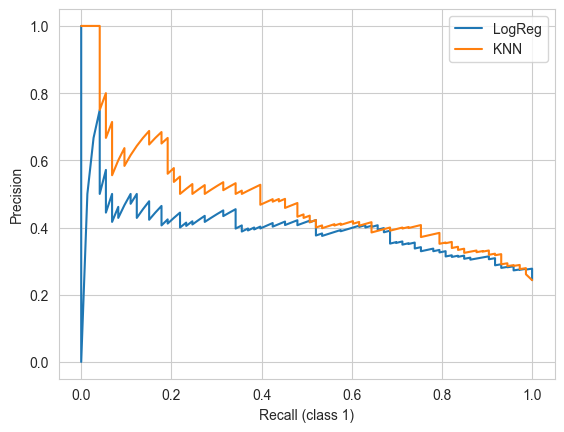

In [152]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p_lr, r_lr, _ = precision_recall_curve(y_test, y_proba_logreg)
p_knn, r_knn, _ = precision_recall_curve(y_test, y_proba_knn)

plt.plot(r_lr, p_lr, label="LogReg")
plt.plot(r_knn, p_knn, label="KNN")
plt.xlabel("Recall (class 1)")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


In [153]:
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)

print("KNN confusion matrix:\n", cm_knn)


KNN confusion matrix:
 [[120 107]
 [ 14  59]]


In [175]:
features_2d = ["tenure_months", "sessions_per_week"]
X2 = X_train[features_2d]


In [176]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2 = pca.fit_transform(X_train_scaled)


In [177]:
from sklearn.neighbors import KNeighborsClassifier

knn_2d = KNeighborsClassifier(
    n_neighbors=best_knn.n_neighbors,
    weights=best_knn.weights,
    p=best_knn.p
)
knn_2d.fit(X2, y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",31
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",1
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


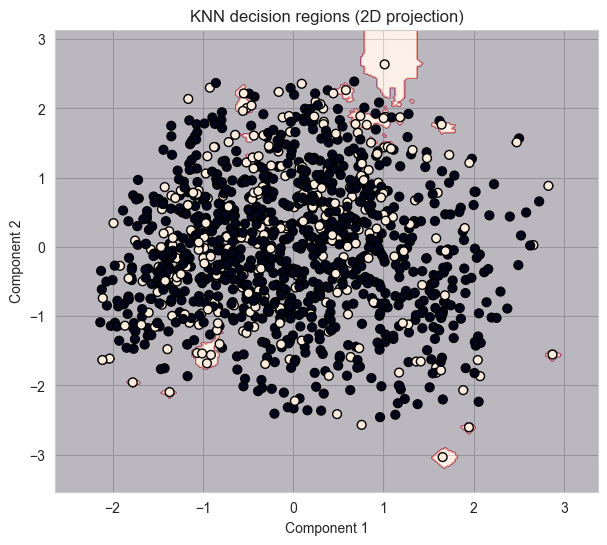

In [178]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2[:, 0], X2[:, 1], c=y_train, edgecolor="k", s=40)
plt.title("KNN decision regions (2D projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [179]:
idx = 5  # index of a test user

distances, indices = best_knn.kneighbors(
    X_test_scaled[idx].reshape(1, -1),
    n_neighbors=best_knn.n_neighbors
)

neighbors = X_train.iloc[indices[0]]
neighbor_labels = y_train.iloc[indices[0]]

print(neighbors)
print(neighbor_labels.value_counts())


      tenure_months  sessions_per_week  feature_usage  support_tickets  \
314               6                 10             48                2   
527               9                  5             49                2   
1145              5                  8             39                2   
1172             10                 11             49                2   
1177              5                 10             41                2   
33                9                 10             38                2   
1315              2                  9             41                2   
389              12                  8             48                1   
1200              9                  9             49                1   
935              10                 11             41                2   
1230              6                  9             49                1   
408              10                  3             46                2   
980              11                  8

# First conclusion: 

at the same churn recall rate (0,81), optimized KNN has higher precision and lower false positive rate (107 vs 116)

In [154]:
def summarize_cm(cm, name):
    tn, fp, fn, tp = cm.ravel()
    recall_1 = tp / (tp + fn)
    precision_1 = tp / (tp + fp)
    print(f"\n{name}")
    print(f"TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")
    print(f"Recall(1): {recall_1:.3f}")
    print(f"Precision(1): {precision_1:.3f}")

summarize_cm(cm_lr, "Logistic Regression")
summarize_cm(cm_knn, "KNN")



Logistic Regression
TP: 59, FN: 14, FP: 116, TN: 111
Recall(1): 0.808
Precision(1): 0.337

KNN
TP: 59, FN: 14, FP: 107, TN: 120
Recall(1): 0.808
Precision(1): 0.355


# Decision tree

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

tree = DecisionTreeClassifier(random_state=42)

param_grid_tree = {
    "max_depth": [None, 3, 4, 5, 6, 8, 10],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_tree,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

best_tree = grid_tree.best_estimator_

print("Tree best params:", grid_tree.best_params_)
print("Tree best CV ROC-AUC:", grid_tree.best_score_)


Tree best params: {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
Tree best CV ROC-AUC: 0.7847764304660856


In [79]:
y_proba_tree = best_tree.predict_proba(X_test)[:, 1]
print("Tree test ROC-AUC:", roc_auc_score(y_test, y_proba_tree))

Tree test ROC-AUC: 0.7881540039828616


In [155]:
from sklearn.metrics import roc_curve
import numpy as np

fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_proba_tree)

target_recall = 0.80
idx_tree = np.where(tpr_tree >= target_recall)[0][0]
thr_tree = thresholds_tree[idx_tree]

print("Tree threshold:", thr_tree)


Tree threshold: 0.32291077397788354


In [157]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_tree = (y_proba_tree >= thr_tree).astype(int)

cm_tree = confusion_matrix(y_test, y_pred_tree)
print("Decision Tree confusion matrix:\n", cm_tree)

print(classification_report(y_test, y_pred_tree))


Decision Tree confusion matrix:
 [[ 53 174]
 [  0  73]]
              precision    recall  f1-score   support

           0       1.00      0.23      0.38       227
           1       0.30      1.00      0.46        73

    accuracy                           0.42       300
   macro avg       0.65      0.62      0.42       300
weighted avg       0.83      0.42      0.40       300



In [158]:
tn, fp, fn, tp = cm_tree.ravel()

recall_1 = tp / (tp + fn)
precision_1 = tp / (tp + fp)

print("TP:", tp, "FN:", fn, "FP:", fp, "TN:", tn)
print("Recall(1):", recall_1)
print("Precision(1):", precision_1)


TP: 73 FN: 0 FP: 174 TN: 53
Recall(1): 1.0
Precision(1): 0.29554655870445345


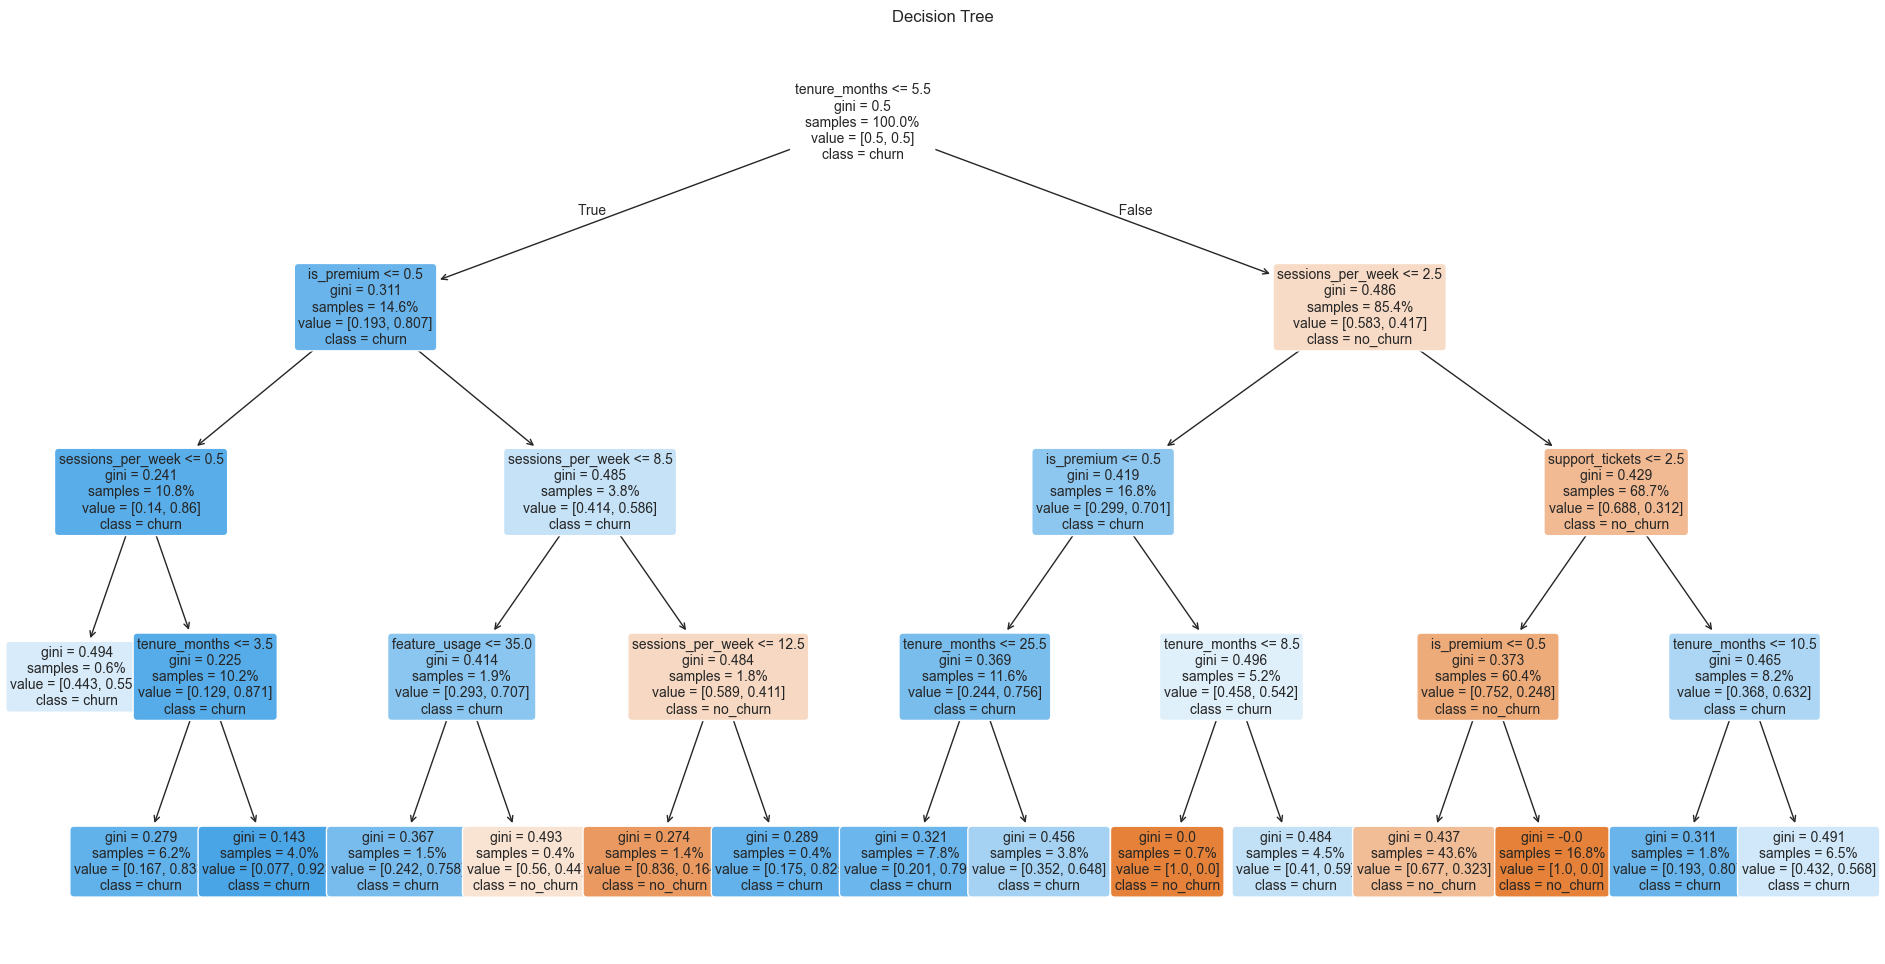

In [160]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 12))
plot_tree(
    best_tree,                       # your fitted DecisionTreeClassifier
    feature_names=X.columns,          # column names from your original X dataframe
    class_names=["no_churn", "churn"],
    filled=True,
    rounded=True,
    impurity=True,
    proportion=True,
    max_depth=4,                      # limit for readability; change as needed
    fontsize=10
)
plt.title("Decision Tree")
plt.show()


In [88]:
from sklearn.tree import export_text

rules = export_text(best_tree, feature_names=list(X.columns), max_depth=4)
print(rules)


|--- tenure_months <= 5.50
|   |--- is_premium <= 0.50
|   |   |--- sessions_per_week <= 0.50
|   |   |   |--- class: 1
|   |   |--- sessions_per_week >  0.50
|   |   |   |--- tenure_months <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- tenure_months >  3.50
|   |   |   |   |--- class: 1
|   |--- is_premium >  0.50
|   |   |--- sessions_per_week <= 8.50
|   |   |   |--- feature_usage <= 35.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_usage >  35.00
|   |   |   |   |--- class: 0
|   |   |--- sessions_per_week >  8.50
|   |   |   |--- sessions_per_week <= 12.50
|   |   |   |   |--- class: 0
|   |   |   |--- sessions_per_week >  12.50
|   |   |   |   |--- class: 1
|--- tenure_months >  5.50
|   |--- sessions_per_week <= 2.50
|   |   |--- is_premium <= 0.50
|   |   |   |--- tenure_months <= 25.50
|   |   |   |   |--- class: 1
|   |   |   |--- tenure_months >  25.50
|   |   |   |   |--- class: 1
|   |   |--- is_premium >  0.50
|   |   |   |--- tenure_months <= 8.50
|   

In [93]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_proba_tree)


0.7881540039828616

# Final comparison

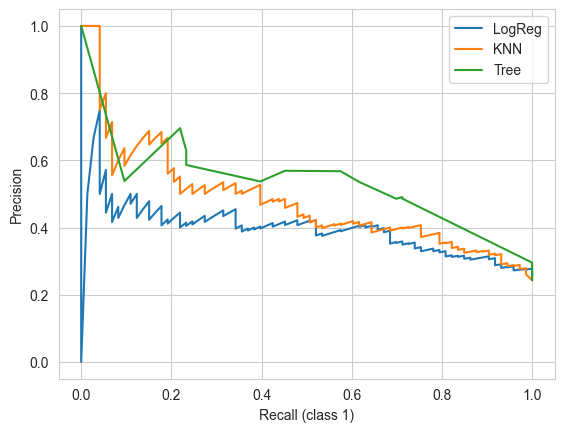

In [96]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p_lr, r_lr, _ = precision_recall_curve(y_test, y_proba_logreg)
p_knn, r_knn, _ = precision_recall_curve(y_test, y_proba_knn)
p_tree, r_tree, _ = precision_recall_curve(y_test, y_proba_tree)

plt.plot(r_lr, p_lr, label="LogReg")
plt.plot(r_knn, p_knn, label="KNN")
plt.plot(r_tree, p_tree, label="Tree")
plt.xlabel("Recall (class 1)")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree_cv = DecisionTreeClassifier(
    **grid_tree.best_params_,
    random_state=42
)

recall_scores = cross_val_score(
    tree_cv,
    X,
    y,
    cv=5,
    scoring="recall"
)

print("Recall CV mean:", recall_scores.mean())
print("Recall CV std:", recall_scores.std())


Recall CV mean: 0.6999619482496195
Recall CV std: 0.03650192375205617


In [100]:
from sklearn.metrics import confusion_matrix

def summarize(y_true, y_proba, threshold, name):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"\n{name}")
    print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(f"Recall(1)={tp/(tp+fn):.3f}, Precision(1)={tp/(tp+fp):.3f}")


In [102]:

def threshold_at_recall(y_true, y_proba, target_recall):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    idx = np.where(tpr >= target_recall)[0][0]
    return thresholds[idx]


In [103]:
target_recall = 0.80

thr_lr   = threshold_at_recall(y_test, y_proba_logreg, target_recall)
thr_knn  = threshold_at_recall(y_test, y_proba_knn, target_recall)
thr_tree = threshold_at_recall(y_test, y_proba_tree, target_recall)

print(thr_lr, thr_knn, thr_tree)



0.16740827436465347 0.17320205415733061 0.32291077397788354


In [173]:
summarize(y_test, y_proba_logreg, best_threshold, "LogReg")
summarize(y_test, y_proba_knn,   best_threshold_knn, "KNN")
summarize(y_test, y_proba_tree,  thr_tree, "Tree")



LogReg
TP=59, FN=14, FP=116, TN=111
Recall(1)=0.808, Precision(1)=0.337

KNN
TP=59, FN=14, FP=107, TN=120
Recall(1)=0.808, Precision(1)=0.355

Tree
TP=73, FN=0, FP=174, TN=53
Recall(1)=1.000, Precision(1)=0.296


# Post-Exercise Reflection Questions
## Model Choice & Business Fit
| Q                                                                                      | Answer      |
| ----------------------------------------------------------------------------------------------------------------- | ----------- |
| Which model would you recommend deploying for XYZ and why?                                                        | I would test the Tree on more data, if our marketing team can process high ampount of false positives. Otherwise, KNN should be more reliable |
| Which business constraint mattered most in your decision (recall, explainability, or consistency of predictions)? | Recall(1) combined with precision and consistency          |
| Would your recommendation change if XYZ were an early-stage startup vs a mature company? Why?                     | Startup has less resources so I would go with KNN and try to contact less people          |

Tree = high variance, brittle, operationally risky
KNN = lower variance, safer default
This is a risk-management decision, not a model-accuracy decision

“The choice is not ‘best model’, but ‘acceptable operational risk’. The tree may outperform on a single split, but KNN is more predictable under drift.”


## Metrics & Trade-offs
| Q                                                                       | Your Answer |
| ------------------------------------------------------------------------------- | ----------- |
| Which evaluation metric did you prioritize and why?                             |  Recall(1)           |
| What are the real business consequences of a false negative in this problem?    |  Customer will churn           |
| What are the real business consequences of a false positive in this problem?    |  Happy customer will be extra contacted  (anyway good bit more workload)         |
| If leadership demanded higher accuracy but lower recall, how would you respond? |  It might make sense if instead of re-engagement emails we would offer discounts or extra services >> lose money on false positive           |

“That implies we are willing to miss more churners in order to reduce spend.
Is that a deliberate budget decision?”


## Bias–Variance as Product Risk
| Question                                                                      | Your Answer |
| ----------------------------------------------------------------------------- | ----------- |
| Did any model show signs of overfitting or underfitting?                      | The tree might be overfitting, recall is suspicious            |
| What product risks does that introduce?                                       |             |
| Would you prefer a slightly underfit or overfit model for this use case? Why? |  overfit will capture less real churns so we prefer underfit          |

Correct framing
Overfit → unstable decisions, hard to trust
Underfit → conservative, predictable, easier to control


## Decision Trees & Explainability
| Question                                                                                                   | Your Answer |
| ---------------------------------------------------------------------------------------------------------- | ----------- |
| How does tree depth or number of leaf nodes affect user experience?                                        |  did not get the question           |
| How does tree depth or number of leaf nodes affect stakeholder trust?                                      |  3-4 is pretty clear and logical           |
| What is the maximum model complexity you would feel comfortable explaining to a non-technical stakeholder? |  depth of 3-4 is fine          |


## Feature Interpretation & Product Insight
| Question                                                                                  | Your Answer |
| ----------------------------------------------------------------------------------------- | ----------- |
| Which features appeared most useful in predicting churn?                                  |    tenure, premiun, and sessions_week         |
| Did any feature surprise you in its impact?                                               |    support tickets had almost no effect         |
| What product hypothesis might explain that?                                               |    seems like product is working fine and there are no critical bugs. ppl churn not because the product is bad but because they don't need it      |
| How could product or UX changes reduce churn for high-risk users identified by the model? |     actions could be:
lifecycle messaging
use-case reactivation
reminders of dormant value
downgrade paths instead of churn     |



## Feature Engineering (Optional Section)
| Question                                                                             | Your Answer |
| ------------------------------------------------------------------------------------ | ----------- |
| Did scaling or normalization change model performance?                               |  yes           |
| From a PM perspective, when would changing feature treatment be acceptable vs risky? |  did not get the question           |


## Threshold & Policy Decisions
| Question                                                                      | Your Answer |
| ----------------------------------------------------------------------------- | ----------- |
| How would you choose a decision threshold for contacting users?               |   based on recal vs precision graph. Threshold = policy decision
Choose threshold based on:
contact capacity
acceptable FP rate
recall target          |
| Would you use different thresholds for premium vs free users? Why or why not? | premium users are much more critical so we better contact even false positives generously,  while on all free users we might not have enough of resources           |


## Shipping & Ethics
| Question                                                                      | Your Answer |
| ----------------------------------------------------------------------------- | ----------- |
| Would you ship this model today? If not, what is missing?                     | I just want to test the tree on more data            |
| What safeguards would you put in place before using this model in production? | Checking it's performance on each more 1k users and raising an alarm if metrics drop. Safeguards are not just metrics:
human override
audit logs
rollback plan
messaging review
Ethics is about who gets affected and how silently.         |
| Who should be accountable if the model makes a bad decision?                  | I guess I as a PM of this project            |


## Final Synthesis Question
In one paragraph:
Explain how you would present this model and its trade-offs to the Head of Marketing.